# <div style="text-align: center">18.335/6.337 Problem Set 5 - Krylov Subspace Methods</div>
## <div style="text-align: center">Due Tuesday, Apr/25 at 11:59 pm</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## General instructions
- Please archive all files (this Jupyter notebook plus other files if any) into a single ZIP file and upload it to the course website, so that the grader can run the Jupyter notebook in the extracted folder without adding anything.  (This greatly simplifies the grader's job.)
- Some questions may require proofs or explanations, and there are a few options to submit them electronically.
    1. Ideally, write down your proofs or explanations in the corresponding sections of this Jupyter notebook.  You can use $\LaTeX$ commands for mathematical symbols, like $A = \hat{U} \Sigma V^*$, $\sum_{j = 1}^{r} \sigma_j u_j v_j^*$, and $\left[
\begin{array}{cc}
 1 & 2 \\
 3 & 4 \\
\end{array}
\right]$.
    2. If you are not familiar with $\LaTeX$ commands, you can use any word processors with equation editors.  If you choose to use this option, make sure to convert the word processor file into PDF before submission.
    3. If none of the above works for you, you can also submit a scan of your handwritten notes as a last resort, but your handwriting must be clear and readable.
- The score of bonus problems, if any, will be added to your total problem set score at the end of the semester.  However, your total problem set score cannot exceed the perfect problem set score without bonus problems.  In other words, 
$$
\text{your total p-set score} = \min\left\{\sum_n\text{your $n$th p-set score $with$ bonus problems}, \sum_n\text{perfect $n$th p-set score $without$ bonus problems}\right\}.
$$
So solve bonus problems to compensate for the deducted points in your problem sets.

## Problem 1.  GMRES [4 pts]

In this problem, we will implement GMRES ourselves.  We will start with implementing the building blocks of GMRES: the Arnoldi iteration and the Givens rotation.

Throughout this problem, assume $A \in \Cmat{m}{m}$ is full-rank.

### Assignment 1.1.  `backsubs!` [1 pt]

In the last stage of GMRES, you need to solve an upper-triangular linear system.  This can be easily done by back substitution.  

Complete `backsubs!` below that implements the back substitution algorithm for solving $R x = b$ for an upper-triangular $R \in \Cmat{m}{m}$ and $b \in \Cvec{m}$.

The function takes two arguments `R` and `b`, which are $R$ and $b$ of the upper-triangular linear system $R x = b$.  After execution of the function, `R` remains the same, but `b` stores the solution $x$.

The basic algorithm is described in Alg. 17.1 of Trefethen and Bau, but you need to modify it into an in-place version, which updates $b$ to $x$.

In [1]:
function backsubs!(R, b)
    m = length(b)

    x = b
    x[m] ./= R[m,m]
    for i = m-1:-1:1
        for j = i+1:m
            x[i] .-= R[i,j] * x[j]
        end
        x[i] ./= R[i,i]
    end
end

backsubs! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `backsubs!`.

In [2]:
m = 5
R = triu(rand(m,m))
b = rand(m)

x = copy(b)
backsubs!(R, x)

println("x ≈ R\\b?  $(x ≈ R\b)")

x ≈ R\b?  true


### Assignment 1.2.  `arnoldi!` [1 pt]

In Step $n$, the Arnoldi iteration orthogonalizes $A q_n$ against the already constructed $n$ Arnoldi vectors $q_1, \ldots, q_n$ to construct a new Arnoldi vector $q_{n+1}$.  

Complete `arnoldi!` below that performs a single Step $n$ of the Arnoldi iteration.  (You can perform the entire Arnoldi iteration by executing `arnoldi!` successively for $n = 1, 2, 3, ...$.)

Here are the descriptions of the four arguments of the function: `n`, `A`, `Q`, and `h`.

- `n` indicates that you are about to execute Step $n$ of the Arnoldi iteration.
- `A` is the $m\times m$ matrix that generates the Krylov subspace.
- `Q` is an $m\times (n_\max+1)$ matrix whose first $n$ ($\le n_\max$) columns are filled with the Arnoldi vectors $q_1, \ldots, q_n$.
- `h` is an empty vector with $n_\max+1$ entries.

After execution of the function,

- `n` and `A` remain the same,
- the $(n+1)$th column of `Q` stores a newly constructed Arnoldi vector $q_{n+1}$, and
- `h` stores the $n$th column of $\tilde{H}_n$ of the Arnoldi iteration; in other words, `h[i]` is the $q_i$-coordinate of $A q_n$ for $i = 1, \ldots, n+1$, and the remaining entries of `h` are unused.


  
  
In the size $m\times (n_\max+1)$ of `Q`, $n_\max$ ($\le m$) is the maximum number of the Arnoldi iteration steps you intend to perform.  You allocate large enough memory for `Q` to perform $n_\max$ steps of the Arnoldi iteration.  The Arnoldi iteration constructs $q_{n_\max+1}$ at Step $n_\max$.  Hence, to store $q_1, \ldots, q_{n_\max}$ and $q_{n_\max+1}$, you need to allocate an $m\times (n_\max+1)$, rather than $m\times n_\max$, matrix for `Q`.

If $n_\max = m$, the Arnoldi vector $q_{n_\max+1}$ constructed in the last Step $n_\max$ must be zero, because you already have $m$ orthonormal Arnoldi vectors.  However, $q_{n_\max+1}$ constructed by the Gram–Schmidt orthogonalizaiton inside the Arnoldi iteration is not exactly zero due to rounding errors.  Therefore, you will need to force $q_{n_\max+1} = 0$ in this case.

`arnoldi!` does not need to `return` anything, because the outputs are stored in the input arguments.

In [3]:
function arnoldi!(n, A, Q, h)
    m = size(A, 1)
    qₙ = @view Q[:,n]
    v = @view Q[:,n+1]

    v .= A*qₙ
    # Alternatively, if you care about avoiding memory allocation, you can do:
    # T = eltype(A)
    # BLAS.gemv!('N', one(T), A, qₙ, zero(T), v)  # v = A * qₙ
    
    lv = norm(v)

    for j = 1:n
        qⱼ = @view Q[:,j]
        h[j] = qⱼ⋅v
        v .-= h[j]*qⱼ
    end
    
    if n < m
        h[n+1] = norm(v)
        v ./= h[n+1]
    else
        h[n+1] = 0
        fill!(v, 0)
    end
end

arnoldi! (generic function with 1 method)

### Validation of your implementation

The following code block performs the Arnoldi iteration for the entire $m$ steps.  Validate your implementation of `arnoldi!` using tihs code block.

In [4]:
m = 10
nmax = 10

A = rand(Complex128, m, m)
Q = zeros(Complex128, m, nmax+1)
H = zeros(Complex128, nmax+1, nmax)

b = rand(Complex128, m)
x₀ = rand(Complex128, m)
r₀ = b - A * x₀

ρ = norm(r₀)
q₁ = r₀ / ρ

Q[:,1] = q₁

for n = 1:nmax
    h = @view H[:,n]
    arnoldi!(n, A, Q, h)
end

println("Hₙ upper-Hessenberg?  $(H == triu(H, -1))")
println("Qₙ* Qₙ ≈ I?  $(Q[:,1:nmax]' * Q[:,1:nmax] ≈ eye(nmax))")
println("AQₙ ≈ Qₙ₊₁H̃ₙ?  $(A*Q[:,1:nmax] ≈ Q*H)")

Hₙ upper-Hessenberg?  true
Qₙ* Qₙ ≈ I?  true
AQₙ ≈ Qₙ₊₁H̃ₙ?  true


### Assignment 1.3.  `givens_h!` [1 pt]

In each iteration step of GMRES, a new column is appended to $\tilde{H}_n$.  This new column has only one nonzero subdiagonal entry, which needs to be removed by a Givens rotation in order to QR-factorize $\tilde{H}_n$.  Before finding the new Givens rotation for this purpose, you first need to apply the previous $n-1$ Givens rotations used to triangularize the previous columns of $\tilde{H}_n$.

Complete `givens_h!` below that carries out the above described procedure.  (The function is meant to take `h` constructed by `arnoldi!`.)

Here are the descriptions of the four arguments of the function: `n`, `c`, `s`, and `h`.

- `n` indicates that you are about to handle the newly appended last column of $\tilde{H}_n$.
- `c` and `s` are vectors with $n_\max$ entries whose first $n-1$ entries are filled with the cosine and sine factors of the Givens rotations used to triangularize the first $n-1$ columns of $\tilde{H}_n$.
- `h` is a vector with $n_\max+1$ entries whose first $n+1$ entries store the last column of $\tilde{H}_n$.  It is constructed by `arnoldi!`.

After execution of the function,

- `n` remains the same,
- the $n$th entries of `c` and `s` store the cosine and sine factors of the Givens rotation used to remove the only subdiagonal entry of the last column of $\tilde{H}_n$, and
- `h` stores `h` transformed by the previous $n-1$ Givens rotations and the newly contructed $n$th Givens rotation; in other words, `h` stores the last column of the $R$ factor of the QR factorization of $\tilde{H}_n$.

`givens_h!` does not need to `return` anything, because the outputs are stored in the input arguments.

In [5]:
function givens_h!(n, c, s, h)
    G = similar(h, 2, 2)  # placeholder for Givens rotation

    # Apply the previously constructed Givens rotations to h.
    for k = 1:n-1
        ck, sk = c[k], s[k]
        G[1,1], G[1,2], G[2,1], G[2,2] = ck', sk', -sk, ck
        h[k:k+1] = G * @view h[k:k+1]
    end

    # Construct a new Givens rotation to nullify the last entry of h.
    d = norm(h[n:n+1])
    c[n] = h[n] / d
    s[n] = h[n+1] / d

    G[1,1], G[1,2], G[2,1], G[2,2] = c[n]', s[n]', -s[n], c[n]
    
    # Nullify the last entry of h using the Givens rotation.
    h[n] = c[n]'*h[n] + s[n]'*h[n+1]
    h[n+1] = 0
end

givens_h! (generic function with 1 method)

### Validation of your implementation

The following code block expands the previous validation code block and triangularizes $\tilde{H}_n$ of the Arnoldi iteration.  Validate your implementation of `givens_h!` using this code block.

In [6]:
m = 10
nmax = 10

A = rand(Complex128, m, m)
Q = zeros(Complex128, m, nmax+1)
R = zeros(Complex128, nmax+1, nmax)
c = zeros(Complex128, nmax)
s = zeros(Complex128, nmax)

b = rand(Complex128, m)
x₀ = rand(Complex128, m)
r₀ = b - A * x₀

ρ = norm(r₀)
q₁ = r₀ / ρ

Q[:,1] = q₁

for n = 1:nmax
    h = @view R[:,n]
    arnoldi!(n, A, Q, h)
    givens_h!(n, c, s, h)    
end

println("R upper-triangular?  $(istriu(R))")

R upper-triangular?  true


### Assignment 1.4.  `gmres!` [1 pt]

Now, using `arnoldi!`, `givens_h!`, and `backsubs!`, complete `gmres!` that solves a system of linear equations $A x = b$ by GMRES.  (The last validation code block already implements the heart of the GMRES iteration, so it would be a good starting point for full-fledged implementation.)

The function takes five arguments: `A`, `b`, `x`, `τ`, and `nmax`.

- `A` and `b` are $A \in \Cmat{m}{m}$ and $b \in \Cvec{m}$ of the equation $A x = b$.
- `x` is an initial guess $x_0$ of the solution.
- `τ` is the tolerance $\tau$ of the stopping criterion $\norm{r_n} / \norm{b} < \tau$.  Its default value is $10^{-6}$.
- `nmax` is the maximum number $n_\max$ of iteration steps you allow in GMRES.  Theoretically, all Krylov subspace methods find the exact solution in at most $m$ steps in exact arithmetic, but in practice they don't finish even after $m$ steps in the presence of rounding errors if the matrix has an unfavorable eigenvalue spectrum.  `nmax` is needed to terminate iteration in such hopless cases.

Execution of the function changes only `x` among all arguments.  After execution of the function, `x` stores either a converged solution satisfying the stopping criterion $\norm{r_n} / \norm{b} < \tau$, or an unconverged solution obtained as a result of premature termination by reaching `nmax` steps.

Additionally, `gmres!` returns two more parameters:

- `n`, the number of iteration steps taken until reaching `x` (i.e., $n$ of $x_n$ stored in `x`), and
- `relres`, a vector with $n_\max+1$ entries whose first $n+1$ entries store the relative residual errors $\frac{\norm{r_0}}{\norm{b}}, \ldots, \frac{\norm{r_n}}{\norm{b}}$.

These two parameters are used to plot the convergence behavior.  Note that `relres[1]` is not $\frac{\norm{r_1}}{\norm{b}}$, but $\frac{\norm{r_0}}{\norm{b}}$.

In [7]:
function gmres!(A, b, x, τ=1e-6, nmax=length(b))
    m = length(b)
    T = eltype(A)

    r₀ = b - A * x
    β = norm(b)
    ρ = norm(r₀)
    ρe₁ = zeros(T, nmax+1)
    ρe₁[1] = ρ

    Q = zeros(T, m, nmax+1)  # need space for one more column qₙ₊₁ constructed by Arnoldi
    R = zeros(T, nmax+1, nmax)
    G = zeros(T, 2, 2)  # placeholder for Givens rotation    
    c = zeros(T, nmax)
    s = zeros(T, nmax)
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖

    Q[:,1] = r₀ / ρ
    r2b = ρ / β
    relres[1] = r2b
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1
        # Construct one more columns of Q and H̃.
        h = @view R[:,n]
        arnoldi!(n, A, Q, h)

        # QR-factorize H̃ into U R using the Givens rotation.
        givens_h!(n, c, s, h)

        # Apply Uₙ* to ρe₁.
        G[1,1], G[1,2], G[2,1], G[2,2] = c[n]', s[n]', -s[n], c[n]
        ρe₁[n:n+1] = G * ρe₁[n:n+1]

        r2b = abs(ρe₁[n+1]) / β  # ρe₁[n+1] = σₙ and |σₙ| = ‖rₙ‖
        relres[n+1] = r2b
    end

    backsubs!((@view R[1:n,1:n]), (@view ρe₁[1:n]))
    x .+= (@view Q[:,1:n]) * (@view ρe₁[1:n])

    return n, relres
end

gmres! (generic function with 3 methods)

### Validation of your implementation

The following code block solves $A x = b$ with your `gmres!` for benchmark $A$ and $b$, and compares its convergence curves for $\tau$- and $n_\max$-terminated cases with the reference convergence curve obtained by a separate GMRES implementation.

If your `gmres!` is implemented correctly, the two sets of convergence data points (`relres1` and `relres2`) obtained by your `gmres!` must lie on the reference curve.  In addition, the convergence data points for the $n_\max$-terminated case (`relres2`) must stop at $n = 30$.

Validate your implementation of `gmres!` using this code block.

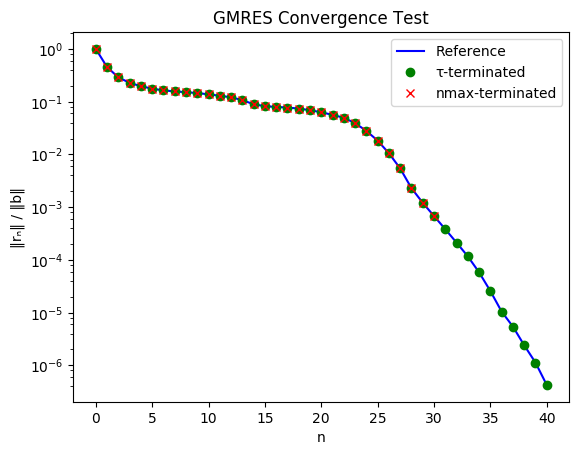

PyObject <matplotlib.legend.Legend object at 0x317e91128>

In [8]:
using JLD

# Load A, b, and reference relres.
@load "bench_gmres.jld"
n = findlast(relres .> 0) - 1

m = size(b)

τ = 1e-6
x = zeros(Complex128, m)
n1, relres1 = gmres!(A, b, x, τ)

nmax = 30
x = zeros(Complex128, m)
n2, relres2 = gmres!(A, b, x, τ, nmax)

using PyPlot
semilogy(0:n, relres[1:n+1], "b-", 0:n1, relres1[1:n1+1], "go", 0:n2, relres2[1:n2+1], "rx")
title("GMRES Convergence Test")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Reference", "τ-terminated", "nmax-terminated"], loc="upper right")


## Problem 2.  CG

In this problem, we will implement CG.  Unlike GMRES, CG uses a short-term recurrence relationship, so its memory usage stays constant throughout the entire iteration.  Therefore, we can use CG to solve much larger linear systems, for which the relative efficiency of iterative solvers compared to direct solvers is greater.  In fact, we will see that for such systems, our crude implementation of CG is indeed much faster than the highly optimized direct solver.

### Assignment 2.1.  `cg!` [1 pt]

Complete `cg!` below that performs CG to solve $A x = b$.  `cg!` takes exactly the same input parameters (`A`, `b`, `x`, `τ`, `nmax`) as `gmres!`, and also returns exactly the same parameters (`n`, `relres`) as `gmres!`.

Because we want to make `cg!` really efficient, here are a few performance tips:

- Use `sumabs2(r)` ([documentation](https://docs.julialang.org/en/stable/stdlib/collections/#Base.sumabs2)) instead of `r⋅r`.
- We need to perform `w = A*v` for some vectors `v` and `w` at every iteration step, but `A*v` allocates a new array everytime it is called.  To avoid this expensive array allocation, preallocate an output array `w` outside the iteration loop and use `A_mul_B!(w, A, v)`([documentation](https://docs.julialang.org/en/stable/stdlib/linalg/#Base.A_mul_B!)) instead.
- For the same reason, use `BLAS.axpy!(α, x, y)` ([documentation](https://docs.julialang.org/en/stable/stdlib/linalg/#Base.LinAlg.BLAS.axpy!)) to perform `y = y + α*x` for a scalar `α` and vectors `x`, `y`.
- To perform `y = α*y + x`, you can transform it to `y = α * (y + (1.0/α)*x)` and use `BLAS.axpy!(1.0/α, x, y)` followed by `y .*= α`.

In [9]:
function cg!(A, b, x, τ=1e-6, nmax=length(b))
    m = length(b)
    T = eltype(A)

    r = b - A * x
    p = copy(r)
    
    lb = norm(b)
    
    rr = sumabs2(r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    Ap = zeros(T, m)
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1

        A_mul_B!(Ap, A, p)  # Ap = A*p
        pAp = p⋅Ap
        
        α = rr / pAp
        BLAS.axpy!(α, p, x)  # x = x + α*p
        
        β = rr  # will be updated later
        BLAS.axpy!(-α, Ap, r)  # r = r - α*Ap
        
        rr = sumabs2(r)
        β = rr / β

        BLAS.axpy!(1.0/β, r, p)  # p = p + (1/β)*r
        p .*= β  # p = β * (p + (1/β)*r) = r + β*p
        
        r2b = sqrt(rr) / lb
        relres[n+1] = r2b
    end

    return n, relres
end

cg! (generic function with 3 methods)

### Validation of your implementation

Now, let's validate your implementation of `cg!` by solving 2D Poisson's equation $-\nabla^2 u(x,y) = f(x,y)$, whose operator happens to be Hermitian positive-definite and therefore is suitable for CG.

The function `poisson2d` that constructs a sparse matrix for 2D Poisson's equation is provided for you.  Also provided is a script that solves Poisson's equation using `poisson2d` and `cg!` and plots the convergence curve and solution.  Run this script to see if your `cg!` produces a matching convergence curve with the reference curve obtained by a separate implementation of CG.  Also see if your numerical solution to 2D Poisson's equation makes sense.  (It has a singularity at the center of the $xy$ domain.)

In [10]:
function poisson2d(∆x, ∆y, Nx, Ny)
    N = Nx*Ny
    ∆x⁻², ∆y⁻² = 1.0/∆x^2, 1.0/∆y^2
    row₀ = reshape(1:N, (Nx,Ny)); col₀ = row₀; val₀ = 2.0(∆x⁻² + ∆y⁻²)

    rowx₊ = row₀[1:end-1,:]; colx₊ = circshift(col₀, (-1,0))[1:end-1,:]; valx₊ = -∆x⁻²
    rowx₋ = row₀[2:end,:]; colx₋ = circshift(col₀, (1,0))[2:end,:]; valx₋ = -∆x⁻²
    rowy₊ = row₀[:,1:end-1]; coly₊ = circshift(col₀, (0,-1))[:,1:end-1]; valy₊ = -∆y⁻²
    rowy₋ = row₀[:,2:end]; coly₋ = circshift(col₀, (0,1))[:,2:end]; valy₋ = -∆y⁻²
    
    A = sparse(row₀[:], col₀[:], val₀, N, N) +
        sparse(rowx₊[:], colx₊[:], valx₊, N, N) +
        sparse(rowx₋[:], colx₋[:], valx₋, N, N) +
        sparse(rowy₊[:], coly₊[:], valy₊, N, N) +
        sparse(rowy₋[:], coly₋[:], valy₋, N, N)

    return A
end

poisson2d (generic function with 1 method)

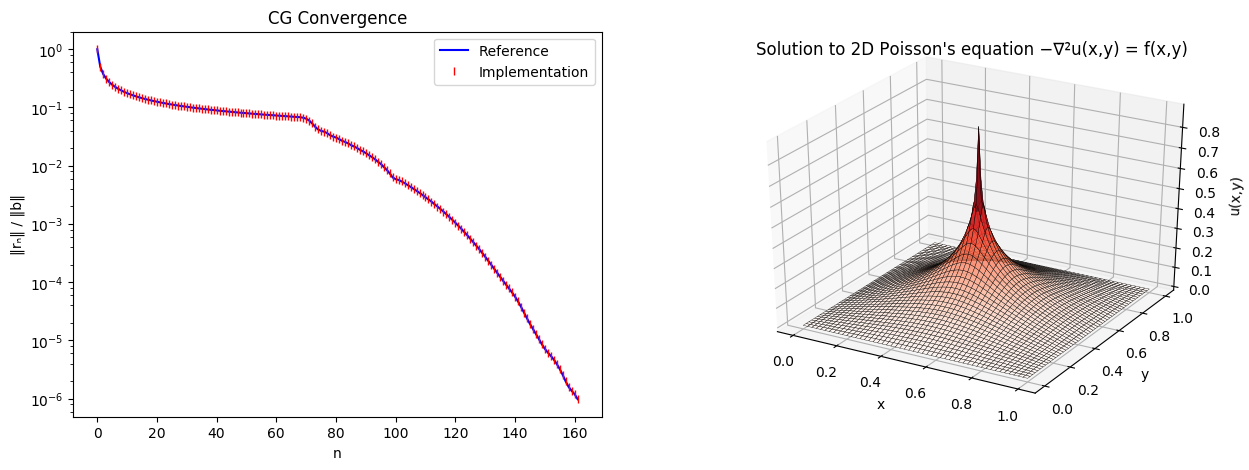

PyObject <matplotlib.text.Text object at 0x322a5f048>

In [11]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Solve the equation by CG.
x = zeros(N)
n1, relres1 = cg!(A, b, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = reshape(x, (Nx,Ny))

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

using JLD
@load "bench_cg.jld"  # load relres
n = findlast(relres .> 0) - 1

subplot(121)
semilogy(0:n, relres[1:n+1], "b-", 0:n1, relres1[1:n1+1], "r|")
title("CG Convergence")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Reference", "Implementation"], loc="upper right")

subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment 2.2.  CG vs. a direct solver [0.5 pts]

We learned that iterative methods can be much faster than direct methods, especially if the matrix is sparse.  Can our suboptimal implementation of CG beat the highly optimized Julia's backslash (`\`) operator?  Let's figure it out.

Complete the following code block that measures times taken by CG and the backslash operator to solve the same 2D Poisson's equation.  To eliminate outliers, solve the equation 20 times and take the median.

Make sure to initialize `x` before feeding it to `cg!`.  If you feed the solution from the previous trial, `cg!` finishes in zero step.

In [27]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Measure solution times.
Ntrial = 20
t_cg = zeros(Ntrial)
t_div = zeros(Ntrial)

for k = 1:Ntrial
    x = zeros(N)
    t_cg[k] = @elapsed cg!(A, b, x)
    t_div[k] = @elapsed A\b
end

@printf "CG is %.2f times faster than backslash." median(t_div)/median(t_cg)

CG is 2.79 times faster than backslash.

## Assignment 2.3.  Matrix-free formulation [2 pts]

Iterative methods use the matrix $A$ only when performing the matrix-vector multiplication $A x$ for some vectors $x$.  Therefore, if we can implement a function that performs the matrix-vector multiplication $A x$ without explicitly constructing the matrix $A$, such a function can be used to implement iterative methods.  This is called the "matrix-free formulation".

The function `apply_poisson2d!` provided below is exactly such a function.  It takes an $N_x \times N_y$ array `u` (like the solution $u(x,y)$ of 2D Poisson's equation), applies the negative Laplacian $-\nabla^2$ to `u`, and stores the result in a $N_x \times N_y$ array `f` (like $f(x,y) = -\nabla^2 u(x,y)$).  The function performs this operation simply by adding and subtracting neighboring entries of `u`, without constructing a matrix.

Complete `cg2d!` below that implements the matrix-free version of `cg!`.  It takes a function `applyA!` instead of the matrix `A`.  Inside `cg2d!`, `applyA!` is used as `applyA!(f,u)` to perform the matrix-vector multiplication without explicitly constructing a matrix.  The subsequent validation code shows how `applyA!` is constructed from `apply_poisson2d!`.

A few hints for implementation:

- `sumabs2` and `BLAS.axpy!` you used in `cg!` also work for array arguments. For example, when `r` is a 2D array, `sumabs2(r)` returns the sum of the absolute squares of all entries of `r`.
- `vecdot(v, w)` works for arrays `v` and `w`.  It conjugates the entries of `v`, multiply them with the corresponding entries of `w`, and sum them.  In other words, `vecdot(v, w)` is the array version of `v⋅w`.

In [13]:
function apply_poisson2d!(f, ∆x, ∆y, Nx, Ny, u)
    N = Nx*Ny
    ∆x⁻², ∆y⁻² = 1.0/∆x^2, 1.0/∆y^2
    
    j = 1
    for i = 1:Nx
        n = sub2ind((Nx,Ny), i, j)
        nx₊ = sub2ind((Nx,Ny), i+1, j)
        nx₋ = sub2ind((Nx,Ny), i-1, j)
        ny₊ = sub2ind((Nx,Ny), i, j+1)

        f[n] = (2u[n] - u[ny₊]) * ∆y⁻²
    end
    
    for j = 2:Ny-1
        for i = 1:Nx
            n = sub2ind((Nx,Ny), i, j)
            nx₊ = sub2ind((Nx,Ny), i+1, j)
            nx₋ = sub2ind((Nx,Ny), i-1, j)
            ny₊ = sub2ind((Nx,Ny), i, j+1)
            ny₋ = sub2ind((Nx,Ny), i, j-1)
            
            f[n] = (2u[n] - u[ny₊] - u[ny₋]) * ∆y⁻²
        end
    end
    
    j = Ny
    for i = 1:Nx
        n = sub2ind((Nx,Ny), i, j)
        nx₊ = sub2ind((Nx,Ny), i+1, j)
        nx₋ = sub2ind((Nx,Ny), i-1, j)
        ny₋ = sub2ind((Nx,Ny), i, j-1)

        f[n] = (2u[n] - u[ny₋]) * ∆y⁻²
    end
    
    i = 1
    for j = 1:Ny
        n = sub2ind((Nx,Ny), i, j)
        nx₊ = sub2ind((Nx,Ny), i+1, j)
        ny₊ = sub2ind((Nx,Ny), i, j+1)
        ny₋ = sub2ind((Nx,Ny), i, j-1)

        f[n] += (2u[n] - u[nx₊]) * ∆x⁻²
    end

    for i = 2:Nx-1
        for j = 1:Ny
            n = sub2ind((Nx,Ny), i, j)
            nx₊ = sub2ind((Nx,Ny), i+1, j)
            nx₋ = sub2ind((Nx,Ny), i-1, j)
            ny₊ = sub2ind((Nx,Ny), i, j+1)
            ny₋ = sub2ind((Nx,Ny), i, j-1)
            
            f[n] += (2u[n] - u[nx₊] - u[nx₋]) * ∆x⁻²
        end
    end

    i = Nx
    for j = 1:Ny
        n = sub2ind((Nx,Ny), i, j)
        nx₋ = sub2ind((Nx,Ny), i-1, j)
        ny₊ = sub2ind((Nx,Ny), i, j+1)
        ny₋ = sub2ind((Nx,Ny), i, j-1)

        f[n] += (2u[n] - u[nx₋]) * ∆x⁻²
    end
end

apply_poisson2d! (generic function with 1 method)

In [14]:
function cg2d!(applyA!, b, x, τ=1e-6, nmax=length(b))
    T = eltype(A)
    Nx, Ny = size(b)
    m = Nx*Ny

    r = zeros(T, Nx, Ny)
    applyA!(r, x)  # r = A*x

    BLAS.axpy!(-1.0, b, r)  # r = r - b
    r .*= -1.0
    
    p = copy(r)
    
    lb = sqrt(sumabs2(b))
    
    rr = sumabs2(r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    Ap = zeros(T, Nx, Ny)
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1

        applyA!(Ap, p)
        pAp = vecdot(p, Ap)

        α = rr / pAp
        BLAS.axpy!(α, p, x)

        β = rr  # will be updated later
        BLAS.axpy!(-α, Ap, r)

        rr = sumabs2(r)
        β = rr / β

        BLAS.axpy!(1.0/β, r, p)
        p .*= β

        r2b = sqrt(rr) / lb
        relres[n+1] = r2b
    end

    return n, relres
end

cg2d! (generic function with 3 methods)

### Validation of your implementation

The following code block performs the same validation as before, but uses `cg2d!` instead of `cg!`.

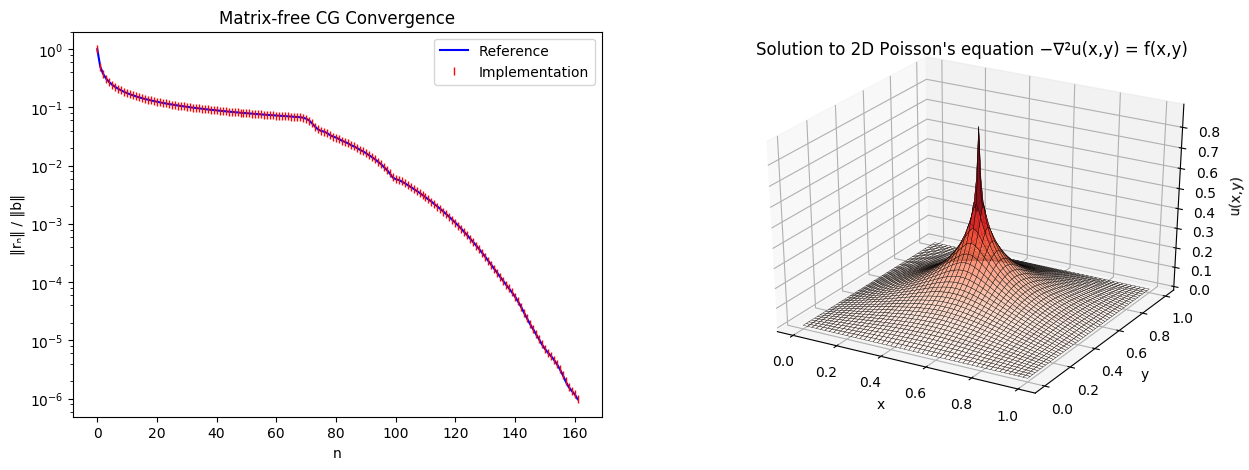

PyObject <matplotlib.text.Text object at 0x322a31550>

In [15]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

applyA!(f, u) = apply_poisson2d!(f, ∆x, ∆y, Nx, Ny, u)

b = zeros(Nx, Ny)
b[cld(Nx,2), cld(Ny,2)] = 1e4

# Solve the equation by matrix-free CG.
x = zeros(Nx, Ny)
n1, relres1 = cg2d!(applyA!, b, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = x

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

using JLD
@load "bench_cg.jld"  # load relres
n = findlast(relres .> 0) - 1

subplot(121)
semilogy(0:n, relres[1:n+1], "b-", 0:n1, relres1[1:n1+1], "r|")
title("Matrix-free CG Convergence")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Reference", "Implementation"], loc="upper right")

subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment 2.4.  Matrix-free CG vs. a direct solver [0.5 pts]

Repeat Assignment 2.2 for `cg2d!`.  Is `cg2d!` faster than `cg!`?

In [29]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

applyA!(f, u) = apply_poisson2d!(f, ∆x, ∆y, Nx, Ny, u)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Measure solution times.
Ntrial = 20
t_cg = zeros(Ntrial)
t_div = zeros(Ntrial)

for k = 1:Ntrial
    u = zeros(Nx, Ny)
    t_cg[k] = @elapsed cg2d!(applyA!, f, u)
    t_div[k] = @elapsed A\b
end

@printf "Matrix-free CG is %.2f times faster than backslash." median(t_div)/median(t_cg)

Matrix-free CG is 4.85 times faster than backslash.

## Problem 3.  Cholesky factorization and ICC [2 pts]

In this problem, we will implement the Cholesky factorization and incomplete Cholesky (ICC) factorization algorithms.

### Assignment 3.1.  `cholesky` [0.5 pts]

Complete `cholesky` below that performs the Cholesky factorization $A = C C^*$ on a Hermitian positive-definite matrix $A \in \Cmat{m}{m}$.

The function takes only one argument `A`, and returns the lower-triangular Cholesky factor $C$ of $A = C C^*$.

In [17]:
function cholesky(A)
    m = size(A,1)
    C = tril(A)
    
    for k = 1:m
        C[k,k] = sqrt(C[k,k])
        for i = k+1:m
            C[i,k] /= C[k,k]
            for j = k+1:i
                C[i,j] -= C[i,k]*conj(C[j,k])
            end
        end
    end
    
    return C
end    

cholesky (generic function with 1 method)

### Validation of your implementation

Validate your implementation of `cholesky` using the following code block.

In [18]:
m = 10
B = rand(Complex128, m, m)
A = B*B'

C = cholesky(A)

println("CC* ≈ A?  $(C*C' ≈A)")

CC* ≈ A?  true


### Assignment 3.2.  `icc` [0.5 pts]

Complete `icc` below that implements the incomplete Cholesky factorization without fill-ins.  The function should not be much different from `cholesky`, and its argument is the same as `cholesky`.

In [19]:
function icc(A)
    m = size(A,1)
    C = tril(A)
    
    for k = 1:m
        C[k,k] = sqrt(C[k,k])
        for i = k+1:m
            A[i,k] ≠ 0 && (C[i,k] /= C[k,k])
            for j = k+1:i
                A[i,j] ≠ 0 && (C[i,j] -= C[i,k]*conj(C[j,k]))
            end
        end
    end
    
    return C
end    

icc (generic function with 1 method)

### Assignment 3.3.  `icc_poisson2d` [1 pt]

Eventually, we want to use `icc` to construct a preconditioner for CG.  However, the above implemented `icc` is prohibitively slow when $A$ becomes larger.  For example, in Prob. 2 we solved 2D Poisson's equation for $N_x = N_y = 99$, but application of `icc` to the matrix for this Poisson's equation takes several minutes.  (You can try this yourself, but please don't try $N_x$ and $N_y$ greater than 40 because it takes too long.)  This is not acceptable, because we are constructing a preconditioner to solve the equation faster: if the construction of a preconditioner takes too long and thus makes the solution procedure slower, there is no reason to construct the preconditioner.

Luckily, there is a way to make `icc` much faster.  `icc` is so slow because it examines every entry of $A$ to check if it is nonzero, but this is unnecessary for the particular matrix for 2D Poisson's equation, because each row of this matrix has at most five nonzero entries and we know exactly the locations of these five entries.  For a start, it is obvious that in the $i$th row the diagonal entry $a_{ii}$ is nonzero.  Additionally, there are at most four more nonzero entries: $a_{i,i\pm1}$ and $a_{i,i\pm N_x}$.  (For this assignment, you can accept this as a fact without understanding it.)  Therefore, when searching for nonzero entries, we need to consider only these five entries instead of the entire $N_x N_y$ entries in each row.

Complete `icc_poisson2d` that accelerates `icc` using the above idea.  `icc_poisson2d` takes an additional argument `Nx` in addition to `A`.

In [20]:
function icc_poisson2d(A, Nx)
    m = size(A,1)
    C = tril(A)
    
    for k = 1:m
        C[k,k] = sqrt(C[k,k])
        for i = (k+1, k+Nx)
            if i ≤ N && A[i,k] ≠ 0
                C[i,k] /= C[k,k]
                for j = (i-Nx, i-1, i)
                    if j ≥ k+1 && A[i,j] ≠ 0
                        C[i,j] -= C[i,k]*conj(C[j,k])
                    end
                end
            end
        end
    end
    
    return C
end    

icc_poisson2d (generic function with 1 method)

### Validation of your implementation

When `icc` and `icc_poisson2d` are implemented correctly, they must create the same incomplete Cholesky factors, though their speeds are very different.  Use the following code block to confirm this for sufficiently small $N_x$ and $N_y$.

In [21]:
Nx, Ny = 11, 21
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny);

C1 = icc(A)
C2 = icc_poisson2d(A, Nx, Ny)
println("C1 == C2?  $(C1==C2)")

LoadError: MethodError: no method matching icc_poisson2d(::SparseMatrixCSC{Float64,Int64}, ::Int64, ::Int64)[0m
Closest candidates are:
  icc_poisson2d(::Any, ::Any) at In[20]:2[0m

## Bonus problem.  Preconditioned CG [3 pts]

In this problem, we will modify `cg!` to `pcg!`, which takes the incomplete Cholesky factor $C$ as a preconditioner.

### Assignment B.1.  `pcg!` [2 pts]

When a linear system $A x = b$ is given for a Hermitian positive-definite $A$, the preconditioned equation by $C$ is

$$
C^{-1} A C^{-*} z = C^{-1} b.
$$

Complete `pcg!` below that performs CG on this preconditioned equation.  Once the solution of this preconditioned equation is found, the solution to the original equation can be recovered by performing $x = C^{-*} z$ in the last stage of `pcg!`.

A few tips for implementation:

- Inside `pcg!`, when applying $C^{-1} A C^{-*}$ to vectors, never construct $C^{-1} A C^{-*}$ directly.  Perform $C^{-1} A C^{-*} v$ for some vector $v$ as $C^{-1} (A (C^{-*} v))$.
- For this problem, don't worry too much about performance.  There are no Julia functions to perform $C^{-*} v$ and $C^{-1} v$ efficiently without array allocation.  If you really want, you can implement back substitution for a sparse matrix yourself.

In [30]:
function pcg!(A, b, C, x, τ=1e-6, nmax=length(b))
    m = length(b)
    T = eltype(A)
    
    z = C' * x  # z₀ = C* x₀

    r = C \ (b - A*x)  # r = C⁻¹b - C⁻¹AC⁻* y₀ = C⁻¹ (b - A x₀)
    
    p = copy(r)
    
    C⁻¹b = C \ b
    lb = norm(C⁻¹b)
    
    rr = sumabs2(r)
    r2b = sqrt(rr) / lb
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖
    relres[1] = r2b
    
    C⁻ᴴp = zeros(T, m)
    AC⁻ᴴp = zeros(T, m)
    Bp = zeros(T, m)
    Clu = lufact(C)
    n = 0
    while n < nmax && r2b ≥ τ
        n += 1

        # Below, B = C⁻¹AC⁻*.
        Ac_ldiv_B!(C⁻ᴴp, Clu, p)
        A_mul_B!(AC⁻ᴴp, A, C⁻ᴴp)
        A_ldiv_B!(Bp, Clu, AC⁻ᴴp)

        pBp = p⋅Bp

        α = rr / pBp
        BLAS.axpy!(α, p, z)

        β = rr  # will be updated later
        BLAS.axpy!(-α, Bp, r)

        rr = sumabs2(r)
        β = rr / β

        BLAS.axpy!(1.0/β, r, p)
        p .*= β

        r2b = sqrt(rr) / lb
        relres[n+1] = r2b
    end

    Ac_ldiv_B!(x, Clu, z)  # x = C⁻* z
    
    return n, relres
end

pcg! (generic function with 3 methods)

### Validation of your implementation.

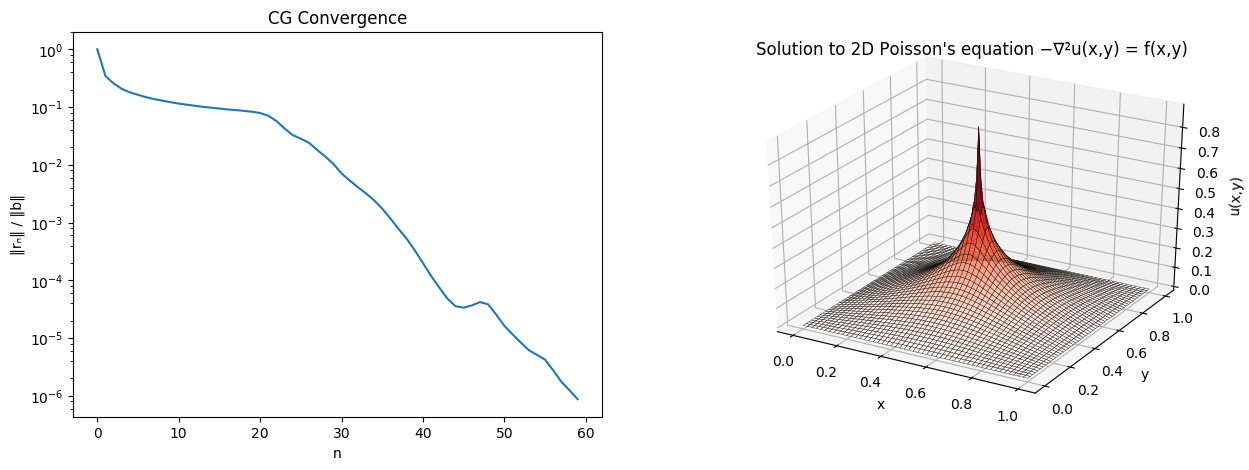

PyObject <matplotlib.text.Text object at 0x3167e1908>

In [32]:
# Construct the problem.
Nx, Ny = 99, 99
N = Nx*Ny
∆x = ∆y = 0.01

A = poisson2d(∆x, ∆y, Nx, Ny)

f = zeros(Nx, Ny)
f[cld(Nx,2), cld(Ny,2)] = 1e4

b = f[:]

# Solve the equation by PCG.
C = icc_poisson2d(A, Nx)
x = zeros(N)
n, relres = pcg!(A, b, C, x)

# Prepare plot data.
u = zeros(Nx+2, Ny+2)
u[2:Nx+1, 2:Ny+1] = reshape(x, (Nx,Ny))

xs = (0:Nx+1)*∆x .+ zeros(Ny+2)'
ys = (0:Ny+1)'*∆y .+ zeros(Nx+2)

# Plot the convergence behavior and the solution.
using PyPlot
figure(figsize=(15,5))

subplot(121)
semilogy(0:n, relres[1:n+1])
title("CG Convergence")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")

subplot(122, projection="3d")
plot_surface(xs, ys, u, rstride=2,edgecolors="k", cstride=2, cmap="Reds", alpha=0.8, linewidth=0.25)
title("Solution to 2D Poisson's equation −∇²u(x,y) = f(x,y)")
xlabel("x")
ylabel("y")
zlabel("u(x,y)")

### Assignment B.2.  Benefit of preconditioning [1 pt]

So, our current `pcg!` is suboptimal in that it does not use efficient routiens for performing $C^{-*} v$ and $C^{-1} v$.  However, in principle we could optimize `pcg!` by implementing efficient routiens for $C^{-*} v$ and $C^{-1} v$.  We want to know if such optimization is worth the effort.

For a specific problem, how can you assess the potential benefit of such optimization?  For the same 2D Poisson's equation with $N_x = N_y = 99$ that was repeatedly used in previous validation code, answer if there is no benefit, great benefit, or only marginal benifit.

***Solution***.

In CG and preconditioned CG, the most expensive parts in each iteration step are evaluation of $A p$ and $C^{-1} A C^{-*} p$, respectively.  Because the number of nonzero entries in $C$ is about a half the number of nonzero entries in $A$, application of $C^{-1}$ or $C^{-*}$ to a vector by back substitution takes about a half the work of $A p$.  Therefore, evaluation of $C^{-1} A C^{-*} p$ takes about $\frac{1}{2} + 1 + \frac{1}{2} = 2$ times as much work as evaluation of $A p$.

Now, we observe that `cg!` and `pcg!` take about 160 and 60 iteration steps, respectively, to solve the same problem.  Because each iteration step in `pcg!` is about twice more expensive than each iteartion step in `cg!`, this is about $\frac{160}{60\times 2} \approx 1.33$ times improvement in time.

Considering extra time taken for creating the preconditioner, this is a marginal improvement.